In [1]:
import sys
import os
print(sys.executable)

# code to generate yearly summaries of DUNE data volumes from input parameters
# rewritten from the version in the CDR - mainly by using maps of years instead of arrays to make it clearer what is in each year.
# HMS 2022-10-23

# if you have json problems, run the program ../strip.py on your file to take off comments
# and then test using https://jsonlint.com
#import numberutils

import os,commentjson

from csv import reader
import json
#import matplotlib.pyplot as plt
#import matplotlib.colors as mcolors

/Users/schellma/miniforge3/envs/my_root_env/bin/python


In [2]:
DEBUG = False
DRAW = True
import numpy as np
#import scipy
import dunestyle.matplotlib as dunestyle

from NumberUtils import dump
from NumberUtils import DrawTex
from NumberUtils import cumulateMap
from NumberUtils import DrawDet
from NumberUtils import DrawType
from NumberUtils import makeArray
from NumberUtils import ToCSV1
from NumberUtils import ToCSV2
from NumberUtils import SumOver1
from NumberUtils import SumOver2
from NumberUtils import TableTex
from NumberUtils import BothTex
from NumberUtils import extendMap
from NumberUtils import makeParameter

from DataHolder import DataHolder

DUNE plot style enabled


In [3]:
# how many histograms to draw in multi-hist plots
N_HISTS = 8   # exhibits all the colors in the Okabe-Ito cycler


# # specify the json file here.  Will create a subdirectory for plots with a similar name

# ## 

# "Tex"# read in a 
# file
# #configfilename = "Parameters_2022-11-21-2040.json"
# 
# #configfilename = "DOE23-NDLAr_2023-11-03-2040b.json"
# #configfilename = "DOE23-NDLAr_2023-12-11-2040.json"  # increase sim for ND

# In[ ]:


configfilename = "Test-2024-02-05-new.json"

#if len(sys.argv) > 1:
#  configfile = sys.argv[1]

In [4]:
shortname = configfilename.replace(".json","")
if os.path.exists(configfilename):
    with open(configfilename,'r') as f:
        #x = f.read()
        #print (x[6000:6960])
        config = commentjson.load(f)
        print ("config file",configfilename,"found")
else:
    print ("no config file",configfilename)
    sys.exit(0)

# if not "Version" in config or config["Version"] < 20:
#     print (" this code expects Version >= 20")
#     sys.exit(1)


config file Test-2024-02-05-new.json found


In [5]:


MWCWeight = config["MWCWeight"] # do we weight cores by available memory? 
MaxYear = config["MaxYear"]
MWCstring = "_noMWC"
if MWCWeight: 
    print ("MWC no longer enabled, ignore")
    MWCstring=""
config["filename"] = configfilename
TEST = config["Test"]
MinYear = config["MinYear"]
Detectors = config["Detectors"]
DataTypes = config["DataTypes"]
NativeTypes = config["NativeTypes"]
if TEST:
    Detectors = config["TestDetectors"]
    DataTypes = config["TestTypes"]
    if "TP" not in DataTypes and "TP" in NativeTypes:
        NativeTypes.remove("TP")
    

Years = config["Years"]

shortname = shortname.replace("2040","%d"%MaxYear)+MWCstring
dirname = shortname
if not os.path.exists(dirname):
    os.mkdir(dirname)
shortname = dirname+"/"+dirname
# make a tex output file
texfilename = dirname+".tex"
texfile = open(texfilename,'w')
tablefile = open(os.path.join(dirname,"tables.tex"),'w')
#texfile.write("\\input{Header.tex}\n")

size = len(Years)
Units = config["Units"]
BaseUnits = config["BaseUnits"]
RequestYear=2024
if "RequestYear" in config:
    RequestYear= config["RequestYear"]
        
Formats = config["Formats"]


Resources = config["Resources"]
Locations = config["Locations"]
PlotDetectors = Detectors+["Total"]
PlotDataTypes = DataTypes+["Total"]
PlotLocations = Locations+["Total"]
Scales = config["Scales"]
Cap = config["Cap"]

BaseMemory = config["Base-Memory"]
Splits= config["Splits"]
PDlist = config["PDlist"]
FDlist = config["FDlist"]
NDlist = config["NDlist"]


print (Detectors)

CombinedDetectors = config["CombinedDetectors"]

DetectorParameters = list(config["SP"].keys())

print ("Parameters",DetectorParameters)


if "Comment" in DetectorParameters:
    DetectorParameters.remove("Comment")

TapeLifetimes = config["TapeLifetimes"]

DiskLifetimes = config["DiskLifetimes"]

TapeCopies = config["TapeCopies"]

DiskCopies = config["DiskCopies"]

# this is how far you go back each time you reprocess reco.
Reprocess = config["Reprocess"]

AnalysisExtend = config["AnalysisExtend"]

PerYear = config["PerYear"]

Slots = config["Slots"]

#StorageTypes = list(TapeCopies.keys())

#print (StorageTypes)
# plot config
DetColors=config["DetColors"]
DetLines = config["DetLines"]
TypeColors=config["TypeColors"]
TypeLines = config["TypeLines"]

PatternFraction = config["PatternFraction"]

# SplitsYear = config["SplitsYear"]
# SplitsEarly = config["SplitsEarly"]
# SplitsLater = config["SplitsLater"]

Explain = config["Explain"]
Explain["filename"] = "Input configuration file"


for f in Explain.keys():

    field = "{\\tt %s:} %s = {\\tt %s} \\\\\n"%(f,Explain[f], config[f])
    field = field.replace("_","\_")
    tablefile.write(field)
    print (Explain[f])

['SP', 'PDHD', 'DP', 'PDVD', 'FDHD', 'FDVD', 'ND-SAND', 'ND-LAr+TMS']
Parameters ['Comment', 'Raw-Data-Store', 'Reco-Data-CPU', 'Reco-Sim-CPU', 'Reco-Data-GPU', 'Reco-Sim-GPU', 'Reco-Data-Store', 'Reco-Sim-Store', 'Reco-Memory', 'Sim-Memory', 'Analysis-CPU']
Detectors included in the calculation
Cap on Raw data per year in PB
MB of memory per slot assumed as the average
Plot until year
Plot starting with year
Number of years of data reprocessed when doing a new pass
Years analysis continues after last reco/sim
Fraction of time taken in pattern recognition
Number of years kept on tape
Number of years kept on disk
Number of copies kept on tape
Number of copies kept on disk
Number of reprocessing done per year
Description of slots, efficiency and speed relative to 2020 vintage
kHEPSPEC06 per core assumed
Input configuration file


## Make data container (holder)

In [6]:
DEBUG = True
#print (config.keys())
holder = DataHolder(theconfig=config,debug=DEBUG)
holder.readTimeline()

csvname = configfilename.replace(".json",".csv")
csvData = holder.csvDump(csvname)

holder.jsonDump(configfilename.replace(".json","safe.json"))

DEBUG= False
holder.debug=DEBUG

if DEBUG: ("Detector Parameters",DetectorParameters)

make a new holder
detectors ['SP', 'PDHD', 'DP', 'PDVD', 'FDHD', 'FDVD', 'ND-SAND', 'ND-LAr+TMS']
Timeline from  NearTerm_2024-02-05-2040-new_timeline.csv
['SP', ' Raw-Events', 'input', 'Total', 'Million', '10.9', '19.4', '6.5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['SP', ' Test', 'input', 'Total', 'TB', '157', '600', '500', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['SP', ' Sim-Events', 'input', 'Total', 'Million', '1.3', '5', '5', '10', '5', '5', '5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['PDHD', ' Raw-Events', 'input', 'Total', 'Million', '0', '0', '0', '0', '0', '0', '20', '5', '5', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['PDHD', ' Test', 'input', 'Total', 'TB', '0', '0', '0', '0', '1000', '1000', '100', '500', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['PDH

# Change input (NativeTypes) into storage numbers

In [7]:
# fill in other useful arrays

DEBUG=True
holder.debug=True
for detector in Detectors:
    print ("--------------- raw-storage ------------------")

    # first raw data events which have to be stored. 
    # Make "input" locations in to "Store" scled by config[detector][type]
    for olddatatype in config["NativeTypes"]:
        oldunits = Scales[olddatatype]
        oldresource = "input"
        newresource = "Store"
        location = "Total"
                 
        if holder.hasTag(detector,olddatatype,oldresource,location,oldunits):
            if DEBUG: holder.printByTag(holder.tag(detector,olddatatype,oldresource,location,oldunits))
            factor = 1
            if olddatatype == "Raw-Events":
                newdatatype = "Raw-Data"
                factor = config[detector]["Raw-Data-Store"]
                newunits = Scales["Raw-Data-Store"]
            else:
                newdatatype = olddatatype
                newunits = oldunits
            # TP and Test are already in units of GB
            if DEBUG: print ("storage",detector,olddatatype,newresource,location,newunits,factor)
            newtag = holder.scale(detector,olddatatype,oldresource,location,oldunits,{"DataTypes":newdatatype,"Resources":newresource,"Units":newunits},factor)
            if DEBUG: holder.printByTag(newtag)
        else:
            print ("could not find", detector,olddatatype,oldresource,location,oldunits)



--------------- raw-storage ------------------

 SP!Raw-Events!input!Total!Million {2018: 10.9, 2019: 19.4, 2020: 6.5, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
storage SP Raw-Events Store Total TB 70
scale: SP!Raw-Events!input!Total!Million
scaleByTag new tag SP!Raw-Events!input!Total!Million SP!Raw-Data!Store!Total!TB
scale 70
SP!Raw-Data!Store!Total!TB

 SP!Raw-Data!Store!Total!TB {2018: 763.0, 2019: 1358.0, 2020: 455.0, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
could not find SP TP input Total TB

 SP!Test!input!Total!TB {2018: 157.0, 2019: 600.0, 2020: 500.0, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0

In [8]:
holder.debug = False

holder.csvDump("after-raw.csv")

# calculate size of raw data coming from detector 

newsubset ['Sub-Total!Raw-Data!Store!Total!TB', 'Sub-Total!Test!Store!Total!TB', 'Sub-Total!Sub-Total!Store!Total!TB']
Draw
Sub-Total not in  {'SP': 'green', 'PDHD': 'green', 'DP': 'magenta', 'PDVD': 'magenta', 'PDs': 'blue', 'FDHD': 'red', 'FDVD': 'red', 'FDs': 'red', 'ND-SAND': 'grey', 'ND-LAr+TMS': 'black', 'Analysis': 'orange', 'Total': 'black', 'MARS': 'purple', 'Production': 'blue', 'US': 'orange', 'CERN': 'cyan', 'Global': 'green', 'Reco-Data': 'red', 'Reco-Sim': 'grey', 'Analysis-Data': 'red', 'Analysis-Sim': 'grey', 'Test': 'green', 'TP': 'purple', 'Raw-Data': 'blue'}
(-2008.75, 42183.75) (-2008.75, 50620.5)


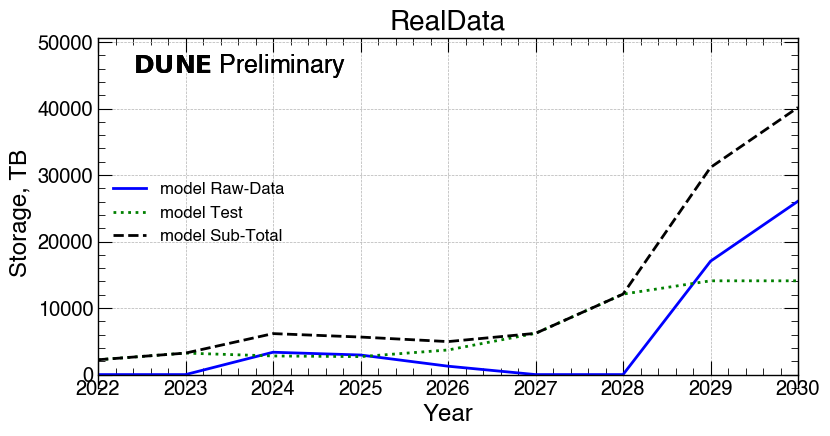

In [9]:
RealDataTypes=["Raw-Data","TP","Test"]

realsubset={"Detectors":Detectors,"DataTypes":RealDataTypes,"Resources":"Store","Locations":"Total"}

realDataTotalDetector=holder.sumAcrossFilters(
    filter=realsubset,sumCat="Detectors",sumName="Sub-Total")

realsubset2={"Detectors":Detectors+["Sub-Total"],"DataTypes":RealDataTypes,"Resources":"Store","Locations":"Total"}

realDataTotalDetectorStore=holder.sumAcrossFilters(
    filter=realsubset2,sumCat="DataTypes",sumName="Sub-Total")
    
newsubset={"Detectors":(["Sub-Total"]),"DataTypes":RealDataTypes+["Sub-Total"],"Resources":"Store","Locations":"Total"}

# holder.storeFilter(newsubset,"real data storage")

# print ("newsubset",holder.makeTagSet(newsubset))

print ("newsubset",holder.makeTagSet(newsubset))
print ("Draw")
holder.Draw(Title="RealData",YAxis="Storage",Category="DataTypes",filter=newsubset)
            
holder.csvDump("realData.csv")

# extend events for Reco and calculate storage/CPU/GPU per year

In [10]:
for detector in Detectors:

    print ("---------------  makereco ------------------") 
    for newdatatype in ["Reco-Data","Reco-Sim"]:
        oldresource = "input"
        if newdatatype == "Reco-Data": 
            olddatatype = "Raw-Events"
        if newdatatype == "Reco-Sim":
            olddatatype = "Sim-Events"
        oldunits = Scales[olddatatype]
        location = "Total"
        # Reco gets reprocessed so has a special cumulation
        for resource in ["CPU","GPU","Store"]:
            newunits = Scales[newdatatype+"-"+resource]    
            if holder.hasTag(detector,olddatatype,oldresource,location,oldunits):
                holder.printByTag(holder.tag(detector,olddatatype,oldresource,location,oldunits))                 
                if DEBUG: print ("--before Events->Things",olddatatype,resource)
                newunits = Scales[newdatatype+"-"+resource]
                factor = config[detector][newdatatype + "-" +resource]*PerYear[newdatatype+"-"+resource]
                if DEBUG: print ("factor",detector,newdatatype,resource,factor)
                newtag = holder.scale(detector,olddatatype,oldresource,location,oldunits,{"DataTypes":newdatatype,"Resources":resource,"Units":newunits},factor)
                holder.printByTag(newtag)
                if DEBUG: print ("--after Events->Things",newdatatype,resource)

                # special to say you redo previous Reprocess years of reco every year.
                if newdatatype == "Reco-Data":  
                    newtag = holder.cumulateMe(detector,newdatatype,resource,location,newunits,{"DataTypes":"Reco-Data"},Reprocess[detector])   
                           
                # extend both Sim and Data for analysis
                if DEBUG:
                    print ("newtag",newtag)
                    print ("Try to extend", detector,newdatatype,resource,location,newunits)
                # if newdatatype in ["Reco-Data","Reco-Sim"]:
                #     nwtag = holder.extendMe(detector,newdatatype,resource,location,newunits,{"DataTypes":newdatatype},AnalysisExtend)
                if DEBUG: holder.printByTag(newtag)


---------------  makereco ------------------

 SP!Raw-Events!input!Total!Million {2018: 10.9, 2019: 19.4, 2020: 6.5, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
--before Events->Things Raw-Events CPU
factor SP Reco-Data CPU 0.1667

 SP!Reco-Data!CPU!Total!MHr {2018: 1.81703, 2019: 3.2339799999999994, 2020: 1.08355, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
--after Events->Things Reco-Data CPU
newtag SP!Reco-Data!CPU!Total!MHr
Try to extend SP Reco-Data CPU Total MHr

 SP!Reco-Data!CPU!Total!MHr {2018: 1.81703, 2019: 5.05101, 2020: 6.13456, 2021: 4.31753, 2022: 1.08355, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029

In [11]:
# Scale by other units

# calculate analysis based on scaling of data/sim

In [12]:
print ("---------------  make analysis ------------------")
for detector in Detectors:
    for resource in ["CPU"]:   
        location = "Total"
        recoAtag = holder.scale(detector,"Reco-Data",resource,location,Scales["Reco-Data-CPU"],{"DataTypes":"Analysis-Data"},config[detector]["Analysis-CPU"]*PerYear["Analysis-CPU"])
        simAtag = holder.scale(detector,"Reco-Sim",resource,location,Scales["Reco-Sim-CPU"],{"DataTypes":"Analysis-Sim"},config[detector]["Analysis-CPU"]*PerYear["Analysis-CPU"])
        # extend
        # extend Analysis
        recoAtag = holder.extendMe(detector,"Analysis-Data",resource,location,Scales["Reco-Data-CPU"],{},AnalysisExtend)
        simAtag = holder.extendMe(detector,"Analysis-Sim",resource,location,Scales["Reco-Sim-CPU"],{},AnalysisExtend)
        print ("make analysis:",recoAtag,simAtag)

holder.csvDump("after-analysis.csv")

---------------  make analysis ------------------
make analysis: SP!Analysis-Data!CPU!Total!MHr SP!Analysis-Sim!CPU!Total!MHr
make analysis: PDHD!Analysis-Data!CPU!Total!MHr PDHD!Analysis-Sim!CPU!Total!MHr
make analysis: DP!Analysis-Data!CPU!Total!MHr DP!Analysis-Sim!CPU!Total!MHr
make analysis: PDVD!Analysis-Data!CPU!Total!MHr PDVD!Analysis-Sim!CPU!Total!MHr
make analysis: FDHD!Analysis-Data!CPU!Total!MHr FDHD!Analysis-Sim!CPU!Total!MHr
make analysis: FDVD!Analysis-Data!CPU!Total!MHr FDVD!Analysis-Sim!CPU!Total!MHr
make analysis: ND-SAND!Analysis-Data!CPU!Total!MHr ND-SAND!Analysis-Sim!CPU!Total!MHr
make analysis: ND-LAr+TMS!Analysis-Data!CPU!Total!MHr ND-LAr+TMS!Analysis-Sim!CPU!Total!MHr


In [20]:
MHrsPerYear = 1000000./365/24.
for detector in Detectors:
    for datatype in DataTypes:
        for oldresource in ["CPU","GPU"]:
            oldunits = "MHr"
            location = "Total"
        
            for newunit in ["Wall","kHS23-Yr","Cores"]:
                
                newresource = oldresource + " " + newunit
                factor = 1./Slots["Efficiency"]/Slots["2020Units"]
                newunits = "MHr"
                if newunit == "kHS23-Yr":
                    factor *= config["kHEPSPEC06PerCPU"]*MHrsPerYear
                    newunits = "kHS23-Yr"
                if newunit == "Cores":
                    newunits = "Cores"
                    factor *= MHrsPerYear
                newtag = holder.scale(detector,datatype,oldresource,location,oldunits,{"DataTypes":datatype,"Resources":newresource,"Units":newunits},factor)
                if newtag != None:
                    print (newtag,holder.holder[newtag])
                

holder.csvDump("after-CPUscale.csv")

WARNING scaleByTag will overwrite existing data SP!Reco-Sim!CPU Wall!Total!MHr
SP!Reco-Sim!CPU Wall!Total!MHr {2018: 1.392857142857143, 2019: 5.357142857142858, 2020: 5.357142857142858, 2021: 10.714285714285715, 2022: 5.357142857142858, 2023: 5.357142857142858, 2024: 5.357142857142858, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
WARNING scaleByTag will overwrite existing data SP!Reco-Sim!CPU kHS23-Yr!Total!kHS23-Yr
SP!Reco-Sim!CPU kHS23-Yr!Total!kHS23-Yr {2018: 1.749021526418787, 2019: 6.727005870841487, 2020: 6.727005870841487, 2021: 13.454011741682974, 2022: 6.727005870841487, 2023: 6.727005870841487, 2024: 6.727005870841487, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
WARNING scaleByTag will overwrite existing data SP!Reco-

-----------------------------------------------------------------------------------
{
    "Detectors": [
        "SP",
        "PDHD",
        "DP",
        "PDVD",
        "FDHD",
        "FDVD",
        "ND-SAND",
        "ND-LAr+TMS"
    ],
    "DataTypes": [
        "Reco-Sim",
        "Reco-Data",
        "Analysis-Data",
        "Analysis-Sim"
    ],
    "Resources": [
        "GPU",
        "CPU",
        "Total",
        "CPU Wall",
        "CPU kHS23-Yr",
        "CPU Cores"
    ],
    "Locations": [
        "Total"
    ]
}
DataTypes ['Raw-Events', 'Sim-Events', 'Raw-Data', 'TP', 'Reco-Sim', 'Reco-Data', 'Test', 'Analysis-Data', 'Analysis-Sim']
(-4.348163, 91.31142299999999) (-4.348163, 109.57370759999999)


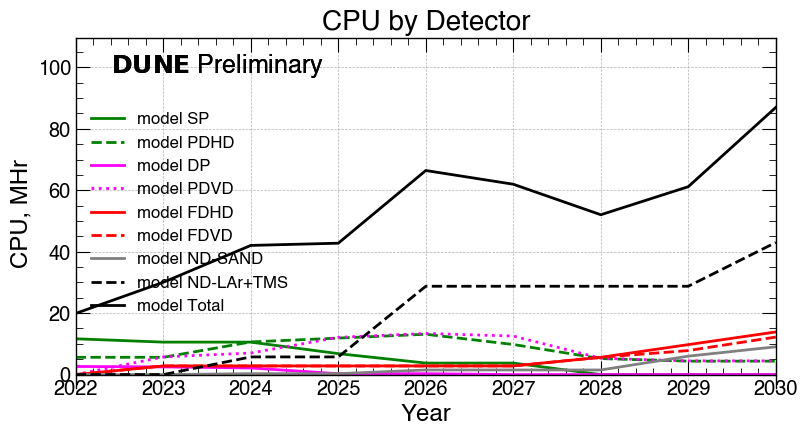

(-3.998093, 91.29475299999999) (-3.998093, 109.55370359999998)


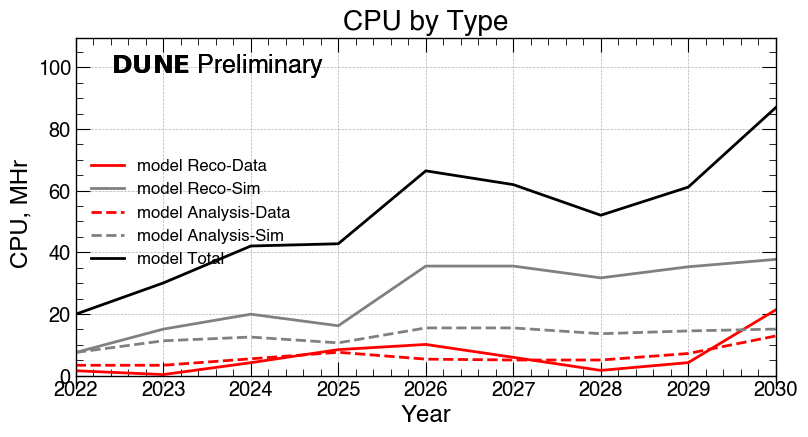

(-6.211661428571429, 130.44489000000002) (-6.211661428571429, 156.533868)


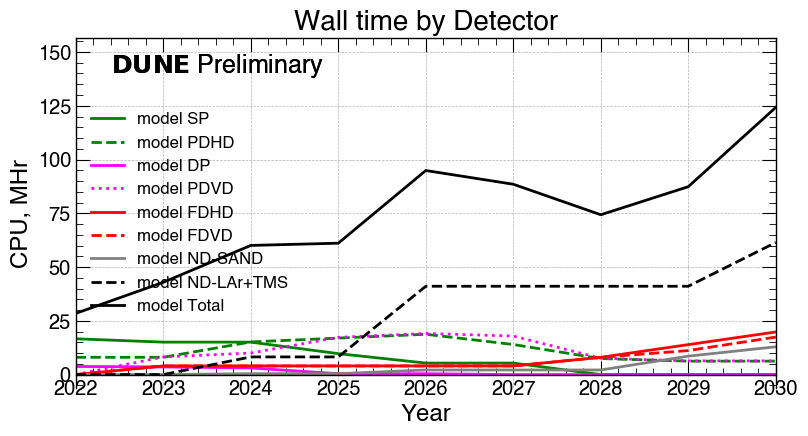

(-5.7115614285714305, 130.42107571428573) (-5.7115614285714305, 156.50529085714288)


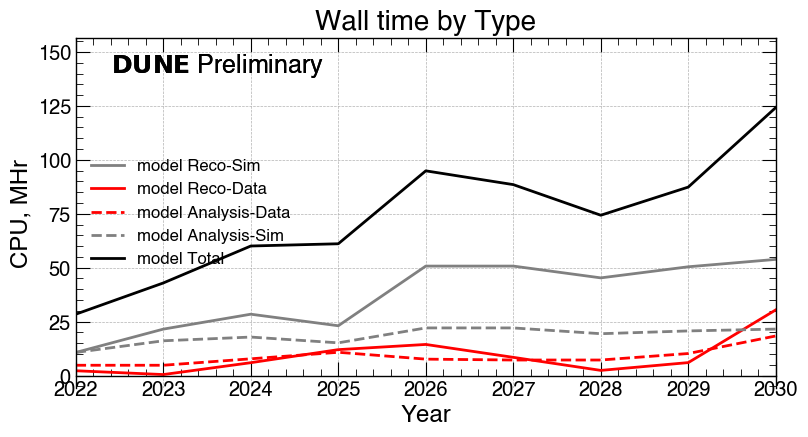

(-7.8000314742335295, 163.8006609589041) (-7.8000314742335295, 196.56079315068493)


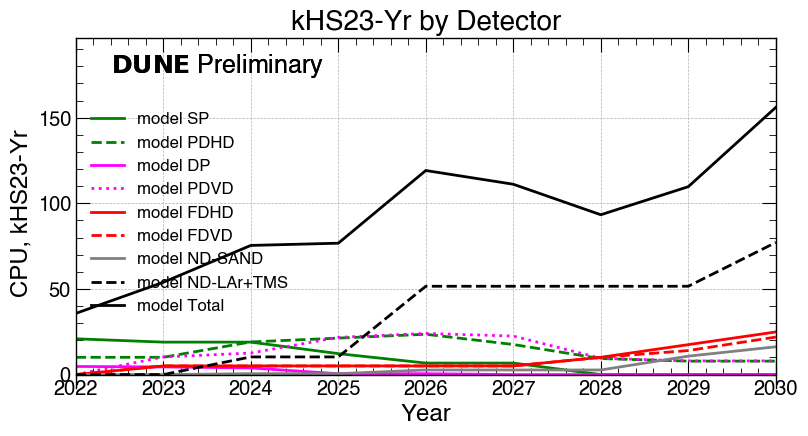

(-7.172052022178735, 163.77075717547294) (-7.172052022178735, 196.5249086105675)


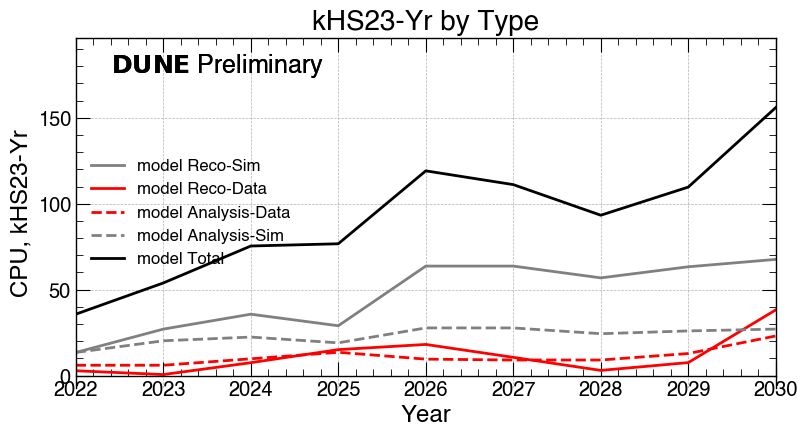

(-709.0937703848663, 14890.969178082192) (-709.0937703848663, 17869.16301369863)


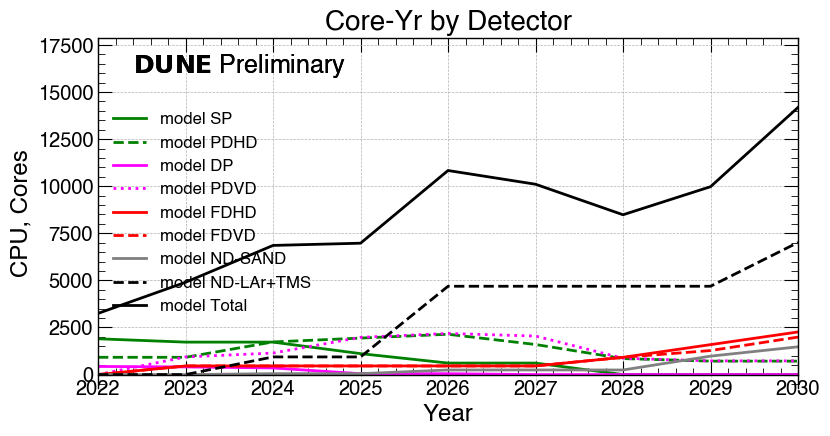

(-652.0047292889759, 14888.25065231572) (-652.0047292889759, 17865.900782778863)


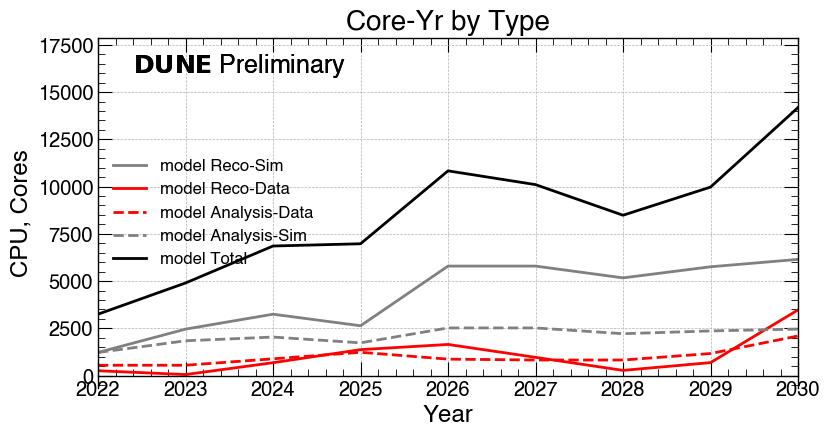

{
    "Detectors": [
        "SP",
        "PDHD",
        "DP",
        "PDVD",
        "FDHD",
        "FDVD",
        "ND-SAND",
        "ND-LAr+TMS"
    ],
    "DataTypes": [
        "Reco-Sim",
        "Reco-Data",
        "Analysis-Data",
        "Analysis-Sim",
        "Total"
    ],
    "Resources": [
        "GPU",
        "CPU",
        "Total",
        "CPU Wall",
        "CPU kHS23-Yr",
        "CPU Cores"
    ],
    "Locations": [
        "Total"
    ]
}


In [22]:
holder.debug = False

# filter on derived event types

CPUTypes = ["GPU","CPU","Total","CPU Wall","CPU kHS23-Yr", "CPU Cores"] 
filter = {"Detectors":Detectors,"DataTypes":["Reco-Sim","Reco-Data","Analysis-Data","Analysis-Sim"],"Resources":CPUTypes,"Locations":["Total"]}
show = json.dumps(filter,indent=4)



CPUTotals=holder.sumAcrossFilters(\
    filter=filter,sumCat="DataTypes",sumName="Total")
holder.csvDump("after-cpu-total.csv")

print("-----------------------------------------------------------------------------------")
print (show)

filter2 = {"Detectors":Detectors,"DataTypes":["Reco-Sim","Reco-Data","Analysis-Data","Analysis-Sim"]+["Total"],"Resources":CPUTypes,"Locations":["Total"]}

CPUTotalsAllDetectors=holder.sumAcrossFilters(filter=filter2, sumCat="Detectors",sumName= "Total")
print ("DataTypes",DataTypes)



CPUByDetector = {"Detectors":Detectors+["Total"],"DataTypes":["Total"],"Resources":["CPU"],"Locations":["Total"]}
CPUByType = {"Detectors":["Total"],"DataTypes":(DataTypes+["Total"]),"Resources":["CPU"],"Locations":["Total"]}
WallByDetector = {"Detectors":Detectors+["Total"],"DataTypes":["Total"],"Resources":["CPU Wall"],"Locations":["Total"]}
WallByType = {"Detectors":["Total"],"DataTypes":(DataTypes+["Total"]),"Resources":["CPU Wall"],"Locations":["Total"]}

kHS23ByDetector = {"Detectors":Detectors+["Total"],"DataTypes":["Total"],"Resources":["CPU kHS23-Yr"],"Locations":["Total"]}
kHS23ByType = {"Detectors":["Total"],"DataTypes":(DataTypes+["Total"]),"Resources":["CPU kHS23-Yr"],"Locations":["Total"]}

CoresByDetector = {"Detectors":Detectors+["Total"],"DataTypes":["Total"],"Resources":["CPU Cores"],"Locations":["Total"]}
CoresByType = {"Detectors":["Total"],"DataTypes":(DataTypes+["Total"]),"Resources":["CPU Cores"],"Locations":["Total"]}


holder.storeFilter(filter=CPUByDetector,name="CPUByDetector")
holder.storeFilter(filter=CPUByType,name="CPUByType")

holder.debug=False


#holder.storeFilter(filter=CPUByType,name="CPUByType")

#print ("CPUByType -list ",holder.filters["CPUByType"])
#holder.debug=False

#CPUTotalsAllDetectors=holder.sumAcrossFilters(filter=filter2, sumCat="Detectors",sumName= "Total")

holder.Draw(Title="CPU by Detector",YAxis="CPU",Category="Detectors",filter=CPUByDetector)

holder.Draw(Title="CPU by Type",YAxis="CPU",Category="DataTypes",filter=CPUByType)

holder.Draw(Title="Wall time by Detector",YAxis="CPU",Category="Detectors",filter=WallByDetector)

holder.Draw(Title="Wall time by Type",YAxis="CPU",Category="DataTypes",filter=WallByType)

holder.Draw(Title="kHS23-Yr by Detector",YAxis="CPU",Category="Detectors",filter=kHS23ByDetector)

holder.Draw(Title="kHS23-Yr by Type",YAxis="CPU",Category="DataTypes",filter=kHS23ByType)

holder.Draw(Title="Core-Yr by Detector",YAxis="CPU",Category="Detectors",filter=CoresByDetector)

holder.Draw(Title="Core-Yr by Type",YAxis="CPU",Category="DataTypes",filter=CoresByType)


holder.csvDump("after-total2.csv")

print (json.dumps(filter2,indent=4))


holder.csvDump("after-analyze.csv")



# make tape and disk and them cumulate

In [23]:
oldresource = "Store"
for detector in Detectors:
    for datatype in DataTypes:
        if datatype in holder.nosum:
            continue
        if datatype in ["Raw-Events","Sim-Events"]: continue
        for newresource in ["Disk","Tape"]:
            for locations in ["Total"]:
                if newresource == "Disk": 
                    factor = DiskCopies[datatype]
                if newresource == "Tape": 
                    factor = TapeCopies[datatype]
                newtag = holder.scale(detector= detector,datatype=datatype,resource=oldresource,location=locations,units="TB",categories={"Resources":newresource},factor=factor)

holder.csvDump("disk-tape.csv")

In [24]:

holder.debug=False
oldlocation = "Total"
for detector in Detectors:
    split = None
    if detector in PDlist:
        split = Splits["PD"]
    elif detector in FDlist:
        split = Splits["FD"]
    elif detector in NDlist:
        split = Splits["ND"]
    if split is None:
        print (detector)
        break
    print (split.keys())
    for datatype in DataTypes:
        if datatype in holder.nosum: continue            
        for resource in ["Disk","Tape","GPU","CPU"]:
            thedatatype = datatype
            
            if resource in ["CPU","GPU"]:  # right now this is generic 
                thedatatype = resource
            for location in Locations:
                if location in holder.nosum: continue
                oldtag = holder.tag(detector,datatype,resource,oldlocation,BaseUnits[resource])
                if oldtag not in holder.holder:
                    if DEBUG: print ("skip split tag",oldtag,)
                    continue
                print ("check", resource,thedatatype,location)
                factor = split[resource][thedatatype][location]
                print ("split",factor)
                newtag = holder.scale(detector= detector,datatype=datatype,resource=resource,location=oldlocation,units="TB",categories={"Locations":location},factor=factor)

holder.csvDump("split.csv")

dict_keys(['Tape', 'Disk', 'CPU', 'GPU'])
skip split tag SP!Raw-Events!Disk!Total!TB
skip split tag SP!Raw-Events!Disk!Total!TB
skip split tag SP!Raw-Events!Disk!Total!TB
skip split tag SP!Raw-Events!Tape!Total!TB
skip split tag SP!Raw-Events!Tape!Total!TB
skip split tag SP!Raw-Events!Tape!Total!TB
skip split tag SP!Raw-Events!GPU!Total!Mhr
skip split tag SP!Raw-Events!GPU!Total!Mhr
skip split tag SP!Raw-Events!GPU!Total!Mhr
skip split tag SP!Raw-Events!CPU!Total!MHr
skip split tag SP!Raw-Events!CPU!Total!MHr
skip split tag SP!Raw-Events!CPU!Total!MHr
skip split tag SP!Sim-Events!Disk!Total!TB
skip split tag SP!Sim-Events!Disk!Total!TB
skip split tag SP!Sim-Events!Disk!Total!TB
skip split tag SP!Sim-Events!Tape!Total!TB
skip split tag SP!Sim-Events!Tape!Total!TB
skip split tag SP!Sim-Events!Tape!Total!TB
skip split tag SP!Sim-Events!GPU!Total!Mhr
skip split tag SP!Sim-Events!GPU!Total!Mhr
skip split tag SP!Sim-Events!GPU!Total!Mhr
skip split tag SP!Sim-Events!CPU!Total!MHr
skip split t

# do the cumulation

In [25]:

for detector in Detectors:
    if detector in holder.nosum: continue
    for datatype in DataTypes:
        print (datatype)
        if datatype in ["Raw-Events","Sim-Events","Total"]: continue
        for newresource in ["Disk","Tape"]:
            for locations in Locations+["Total"]:
                if newresource == "Disk": 
                    retain = DiskLifetimes[datatype]
                    retresource = "Cumulative-Disk"

                if newresource == "Tape": 
                    retain = TapeLifetimes[datatype]
                    retresource = "Cumulative-Tape"

                newertag = holder.cumulateMe(detector=detector,datatype=datatype,resource=newresource,location=locations,units="TB",categories={"Resources":retresource},period=retain)
                # and extend
                if ("Reco" in datatype and newresource == "Disk"):
                    print ("extend by ",AnalysisExtend,newtag)
                    newertag = holder.extendMe(detector,datatype,newresource,location,"TB",{},AnalysisExtend)
                print (newertag)
                
holder.csvDump("cumulate.csv")



            
                


Raw-Events
Sim-Events
Raw-Data
SP!Raw-Data!Cumulative-Disk!US!TB
SP!Raw-Data!Cumulative-Disk!CERN!TB
SP!Raw-Data!Cumulative-Disk!Global!TB
SP!Raw-Data!Cumulative-Disk!Total!TB
SP!Raw-Data!Cumulative-Disk!Total!TB
SP!Raw-Data!Cumulative-Tape!US!TB
SP!Raw-Data!Cumulative-Tape!CERN!TB
SP!Raw-Data!Cumulative-Tape!Global!TB
SP!Raw-Data!Cumulative-Tape!Total!TB
SP!Raw-Data!Cumulative-Tape!Total!TB
TP
cannot cumulate missing tag SP!TP!Disk!US!TB
None
cannot cumulate missing tag SP!TP!Disk!CERN!TB
None
cannot cumulate missing tag SP!TP!Disk!Global!TB
None
cannot cumulate missing tag SP!TP!Disk!Total!TB
None
cannot cumulate missing tag SP!TP!Disk!Total!TB
None
cannot cumulate missing tag SP!TP!Tape!US!TB
None
cannot cumulate missing tag SP!TP!Tape!CERN!TB
None
cannot cumulate missing tag SP!TP!Tape!Global!TB
None
cannot cumulate missing tag SP!TP!Tape!Total!TB
None
cannot cumulate missing tag SP!TP!Tape!Total!TB
None
Reco-Sim
extend by  3 None
SP!Reco-Sim!Disk!Total!TB
extend by  3 None
SP!Reco

In [ ]:
StorageTypes=["Tape","Disk","Cumulative-Tape","Cumulative-Disk"]

Storage = {"Detectors":Detectors,"DataTypes":DataTypes,"Resources":StorageTypes,"Locations":Locations}
#Tape = {"Detectors":Detectors,"DataTypes":DataTypes,"Resources":"Tape","Locations":Locations}
holder.debug=True
holder.sumAcrossAll(filter=Storage,sumName="Total")
holder.debug=False

holder.csvDump("sumacross.csv")

In [ ]:


# StorageTotalsAllDetectors=holder.sumAcrossFilters(filter=Storage, sumCat="Detectors",sumName= "Total")
holder.debug = False
Storage = {"Detectors":Detectors+["Total"],"DataTypes":DataTypes+["Total"],"Resources":StorageTypes,"Locations":["Total"]}

print (Storage)

check = holder.makeTagSet(Storage)
for i in check:
    if "Total" in i: print (i)


## Define subsamples to plot

In [ ]:

# StorageTotalsAllResources=holder.sumAcrossFilters(filter=Storage, sumCat="Resources",sumName= "otal")

Storage = {"Detectors":(Detectors+["Total"]),"DataTypes":DataTypes+["Total"],"Resources":StorageTypes,"Locations":["Total"]}

GenericStorage =  {"Detectors":["Total"],"DataTypes":DataTypes+["Total"],"Resources":["Store"],"Locations":["Total"]}


TapeStorage = {"Detectors":["Total"],"DataTypes":DataTypes+["Total"],"Resources":["Tape"],"Locations":["Total"]}

CumulativeTapeStorage = {"Detectors":["Total"],"DataTypes":DataTypes+["Total"],"Resources":["Cumulative-Tape"],"Locations":["Total"]}

DiskStorage = {"Detectors":["Total"],"DataTypes":DataTypes+["Total"],"Resources":["Disk"],"Locations":["Total"]}

CumulativeDiskStorage = {"Detectors":["Total"],"DataTypes":DataTypes+["Total"],"Resources":["Cumulative-Disk"],"Locations":["Total"]}


DiskStorageBySite = {"Detectors":["Total"],"DataTypes":["Total"],"Resources":["Disk"],"Locations":Locations+["Total"]}
DiskStorageByDetector = {"Detectors":Detectors,"DataTypes":["Total"],"Resources":["Disk"],"Locations":["Total"]}
TapeStorageBySite = {"Detectors":["Total"],"DataTypes":["Total"],"Resources":["Tape"],"Locations":Locations+["Total"]}
TapeStorageByDetector = {"Detectors":Detectors,"DataTypes":["Total"],"Resources":["Tape"],"Locations":["Total"]}

CumulativeDiskStorageByDetector = {"Detectors":Detectors,"DataTypes":["Total"],"Resources":["Cumulative-Disk"],"Locations":["Total"]}
CumulativeDiskStorageBySite = {"Detectors":["Total"],"DataTypes":["Total"],"Resources":["Cumulative-Disk"],"Locations":Locations+["Total"]}
CumulativeTapeStorageByDetector = {"Detectors":Detectors,"DataTypes":["Total"],"Resources":["Cumulative-Tape"],"Locations":["Total"]}
CumulativeTapeStorageBySite = {"Detectors":["Total"],"DataTypes":["Total"],"Resources":["Cumulative-Tape"],"Locations":Locations+["Total"]}



In [ ]:


holder.Draw("New Tape by Type",YAxis="Storage",Category="DataTypes",filter=TapeStorage)
holder.Draw("New Tape by Detector",YAxis="Storage",Category="Detectors",filter=TapeStorageByDetector)
holder.Draw("New Tape by Site",YAxis="Storage",Category="Locations",filter=TapeStorageBySite)
holder.Draw("Cumulative Tape by Type",YAxis="Storage",Category="DataTypes",filter=CumulativeTapeStorage)
holder.Draw("Cumulative Tape by Detector",YAxis="Storage",Category="Detectors",filter=CumulativeTapeStorageByDetector)
holder.Draw("Cumulative Tape by Site",YAxis="Storage",Category="Locations",filter=CumulativeTapeStorageBySite)



In [ ]:

holder.Draw("New Disk by Type",YAxis="Storage",Category="DataTypes",filter=DiskStorage)
holder.Draw("New Disk by Detector",YAxis="Storage",Category="Detectors",filter=DiskStorageByDetector)
holder.Draw("New Disk by Site",YAxis="Storage",Category="Locations",filter=DiskStorageBySite)
holder.Draw("Cumulative Disk by Type",YAxis="Storage",Category="DataTypes",filter=CumulativeDiskStorage)
holder.Draw("Cumulative Disk by Detector",YAxis="Storage",Category="Detectors",filter=CumulativeDiskStorageByDetector)
holder.Draw("Cumulative Disk by Site",YAxis="Storage",Category="Locations",filter=CumulativeDiskStorageBySite)



In [ ]:


# holder.Draw("New Disk by year",YAxis="Storage, TB",Category="DataTypes",filter=DiskStorage)
# holder.Draw("Cumulative-Disk",YAxis="Storage, TB",Category="DataTypes",filter=CumulativeDiskStorage)

# holder.Draw("Yearly Disk Sites",YAxis="Storage, TB",Category="Locations",filter=DiskStorageBySite)
# holder.Draw("Yearly Tape Sites",YAxis="Storage, TB",Category="Locations",filter=TapeStorageBySite)

# holder.Draw("Cumulative Disk Sites",YAxis="Storage, TB",Category="Locations",filter=CumulativeDiskStorageBySite)
# holder.Draw("Cumulative Tape Sites",YAxis="Storage, TB",Category="Locations",filter=CumulativeTapeStorageBySite)



               
            




In [ ]:


# EventTags = []
# RecoCPUTags = []

# for detector  in Detectors:
#     EventTags.append(holder.tag(detector,"Raw-Data","Store","Total",Scales["Raw-Data-Store"]))
#     RecoCPUTags.append(holder.tag(detector,"Reco-Data","CPU","Total",Scales["Reco-Data-CPU"]))
#     CPUTags
# if DRAW: CPUholder.Draw("CPU by Detector","Total","Detectors")

# sys.exit(1)
if DRAW: holder.Draw("Test1","Raw-Data","Detectors",EventTags)
if DRAW: holder.Draw("CPU","Reco-Data","Detectors",RecoCPUTags)

    # for datatype in ["Analysis"]:  # keep analyzing for a few years. 
    #     for resource in Resources:
    #         for location in Locations:
    #             newtag = holder.cumulateMe(detector,datatype,resource,location,"Datatypes",resource,factor)
       
    #     mc = extendMap(Years,Inputs[det]["Sim-CPU"],AnalysisExtend)
    #     if DEBUG: print ("mc",mc)
    #     for year in Years:
    #         total = data[year]
    #         total += mc[year]
    #         Inputs[det][key][year] = total *config[det]["Analysis-CPU"]  # this scales by a factor relative to reco/sim-MWC
        
    #     if DEBUG: print ("other key",det,key)



# do a little cleanup

# for det in Inputs.keys():
    
#     if "Sim-Memory" in Inputs[det]:
#         Inputs[det].pop("Sim-Memory")
#     if "Reco-Memory" in Inputs[det]:
#         Inputs[det].pop("Reco-Memory")


# In[ ]:


# make a data file which uses # of events to figure out how big samples are


In [ ]:

if PerYear["Reco-Data-Store"]!=PerYear["Reco-Data-CPU"]:
    print ("Data growth has to match reprocessing cycles/year")
    PerYear["Reco-Data-Store"] = PerYear["Reco-Data-CPU"]
if PerYear["Reco-Sim-Store"]!=PerYear["Reco-Sim-CPU"]:
    print ("Sim growth has to match reprocessing cycles/year")
    PerYear["Reco-Sim-Store"] = PerYear["Reco-Sim-CPU"]

#Data = {}
#dump = open("dump.txt",'w')

    
#print (Inputs.keys())
# fields = config["Scales"]
# print ("fields",fields)
# for dtype in fields:
#     Data[dtype] = {}
#     if "Memory" in dtype:
#         continue
#     for det in Detectors:
        
#         # this allows you to, say, do 2 passes of reco/year
        
#         # print("makeData",dtype, det, Inputs[det][dtype][year])
#         for year in Years:
#             Data[dtype][det][year] = float(Inputs[det][dtype][year]) * float(PerYear[dtype])
#         # compensate for nominal units being millions and TB or singles and MB
#         if Units[dtype] == "PB":
#             for year in Years:
#                 Data[dtype][det][year] *= 0.001
#         ds = "data %s %s %f\n"%(dtype,det,Data[dtype][det][2022])
#         dump.write(ds)


# - impose a cap at Cap (30 PB/year if set)

# In[ ]:


# impose a cap at Cap on things derived from raw data




In [ ]:

dtype = "Raw-Store"

Data["Raw-Store"]["Total"] = {}
for year in Years:
    Data[dtype]["Total"][year] = 0.0
for det in Inputs.keys():

    for year in Years:
        
        Data[dtype]["Total"][year] +=  Data["Raw-Store"][det][year]
        
dtypes = ["Raw-Store"] #,"Reco-Data-CPU"]
for dtype in dtypes:
    for det in Inputs.keys():
        #print (dtype,det,2035,1.0,Data[dtype][det][2035] )
        for year in Years:
            cap = Data["Raw-Store"]["Total"][year]/Cap
           # print (dtype,det,year,cap,Data[dtype][det][year] )
            if cap > 1:
                Data[dtype][det][year] /=cap
        #print (dtype,det,2035,cap,Data[dtype][det][2035] )


# # Make a total across detectors

# In[ ]:


In [ ]:


dtypes = ["Raw-Store","Reco-Data-Store","Sim-Store","Reco-Data-CPU","Sim-CPU","Analysis-CPU"]



for dtype in dtypes:
    Data[dtype]["Total"] ={}
    
        
    for year in Years:
        Data[dtype]["Total"][year] = 0.0
    for det in Inputs.keys():
        #if dtype != "Analysis":  # not certain what this does... I think it is leftover. 
        for year in Years:
            Data[dtype]["Total"][year]+=  Data[dtype][det][year] 
    
             
    


# In[ ]:


PlotYears = []
for i in range(MinYear,MaxYear+1):
    PlotYears.append(i)


# In[ ]:


PlotYears = []
for i in range(MinYear,MaxYear+1):
    PlotYears.append(i)
#PlotYears = Years
print ("PlotYears",PlotYears)
# draw things
things = list(Inputs.keys())+["Total"]

if DRAW:
    for stuff in ["Raw-Events","Test","Sim-Events","Raw-Store","Reco-Data-Store","Sim-Store","Reco-Data-CPU","Sim-CPU","Analysis-CPU","Reco-Data-GPU","Sim-GPU"]:
        DrawDet(shortname,stuff,PlotYears,Data,things,Units,DetColors,DetLines)

ToCSV2(shortname+"-Reco-Data-GPU","Reco-Data-GPU",PlotYears,Data,Units,Formats)
ToCSV2(shortname+"-Sim-GPU","Sim-GPU",PlotYears,Data,Units,Formats)


# In[ ]:


PlotYears = []
for i in range(MinYear,MaxYear+1):
    PlotYears.append(i)
#PlotYears = Years
print ("PlotYears",PlotYears)
# draw things
things = list(Inputs.keys())+["Total"]

print (Inputs.keys())
other = list(Inputs["ND-SAND"].keys())+["Total"]

print (other)


if DRAW:
    for stuff in ["Raw-Events","Test","Sim-Events","Raw-Store","Reco-Data-Store","Sim-Store","Reco-Data-CPU","Sim-CPU","Analysis-CPU"]:
        DrawDet(shortname,stuff,PlotYears,Data,things,Units,DetColors,DetLines)



# In[ ]:





# In[ ]:



# merge protodune info

if DEBUG: print ("Data keys",Data.keys())

for dtype in Data.keys():
    if DEBUG: print ("Merge protodunes",dtype)
    det = "PDs" 
    Data[dtype][det] = {}
    for year in Years:  
        Data[dtype][det][year] = Data[dtype]["SP"][year] + Data[dtype]["DP"][year] + Data[dtype]["PDHD"][year] + Data[dtype]["PDVD"][year]

    Data[dtype].pop("SP")
    Data[dtype].pop("PDHD")
    Data[dtype].pop("DP")
    Data[dtype].pop("PDVD")
    


# In[ ]:


# merge far detector into "FDs
if "HD" in Detectors and "VD" in Detectors:
    for dtype in Data.keys():
        det = "FDs"
        print ("merge FDS",dtype)
        Data[dtype][det] =  {}
        for year in Years:  
            Data[dtype][det][year] = Data[dtype]["HD"][year] + Data[dtype]["VD"][year]
        Data[dtype].pop("HD")
        Data[dtype].pop("VD")
        
# for dtype in Data.keys():
#         det = "FDs"
#         Data[dtype][det] =  {}
#         for year in Years:  
#             Data[dtype][det][year] = 0
        
# for subdet in ["Calib","HighE","LowE","LBL","Calib","TP"]:
#     for dtype in Data.keys():
#         det = "FDs"
#         print ("merge FDS",dtype)
        
#         for year in Years:  
#             Data[dtype][det][year] += Data[dtype][subdet][year] 
#         Data[dtype].pop("subdet")


# In[ ]:


# make a total CPU category

Data["Total-CPU"]={}

for det in CombinedDetectors:
    Data["Total-CPU"][det] =  {}
    for year in Years:
        Data["Total-CPU"][det][year] = Data["Reco-Data-CPU"][det][year] + Data["Sim-CPU"][det][year] + Data["Analysis-CPU"][det][year]
    #print(det,Data["Total-CPU"][det])


# In[ ]:


# make totals across categories. 

DataTypes = list(Data.keys())

for dt in DataTypes:
    Data[dt]["Total"] = {}
    for year in Years:
        Data[dt]["Total"][year]=0.0
    for k in Data[dt].keys():
        if k == "Total":
          continue  
        for year in Years:
            Data[dt]["Total"][year] += Data[dt][k][year]
    


# In[ ]:


# and make a special data type for cores

Data["Cores"] = {}
Data["HS23"] = {}
Data["Wall"] = {}
 
MHrsPerYear = 1000000/365./24.
print ("MHrsPerYear",MHrsPerYear)
print ("total-CPU keys",Data["Total-CPU"].keys())
for k in Data["Total-CPU"].keys():
#     if "MARS" not in k :
#         efficiency = config["Cores"]["Efficiency"]
#     else:
#         efficiency = 1

    scaleTo2020 = config["Cores"]["2020Units"]
    Data["Cores"][k]={}
    Data["Wall"][k]={}
    Data["HS23"][k]={}
#    Data["WALL"][k]={}
    for year in Years:
        Data["Wall"][k][year] = Data["Total-CPU"][k][year]/scaleTo2020/efficiency
        Data["Cores"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/scaleTo2020/efficiency
        Data["HS23"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/scaleTo2020/efficiency*config["kHEPSPEC06PerCPU"]
#        Data["WALL"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020


# # Yearly info:

# In[ ]:


Types = CombinedDetectors+["Analysis","Total"] 
if DRAW:
    DrawDet(shortname+"_byyear","Total-CPU",PlotYears,Data,Types,Units,DetColors,DetLines)#,cpuactual)
    DrawDet(shortname+"_byyear","Cores",PlotYears,Data,Types,Units,DetColors,DetLines)#,coreactual)
    DrawDet(shortname+"_byyear","Wall",PlotYears,Data,Types,Units,DetColors,DetLines)#,wallactual)
    DrawDet(shortname+"_byyear","HS23",PlotYears,Data,Types,Units,DetColors,DetLines)#,wallactual)


# In[ ]:


#  for Storage work out split between different institutions

Splits = {}
for f in SplitsEarly:
    Splits[f] = {}
    for t in SplitsEarly[f]:
        Splits[f][t] = {}
        for loc in SplitsEarly[f][t]: 
            Splits[f][t][loc] = {}
            #print (f,t,Splits[f][t],Splits[f][t][0])
    
            for y in Years:
                if y < SplitsYear:
                    Splits[f][t][loc][y]=SplitsEarly[f][t][loc]
                else:
                    Splits[f][t][loc][y]=SplitsLater[f][t][loc]


# In[ ]:


if DEBUG: print (Splits["CPU"])

for key in ["Total-CPU","Cores","HS23","Wall"]: 
    
    for site in ["FNAL","CERN","Global"]:
        Data[key][site] = {}
        for year in Years:
            
            Data[key][site][year] = Data[key]["Total"][year]*Splits["CPU"]["CPU"][site][year]
            


# # here is where we start doing cumulation across years for disk and reconstruction

# In[ ]:


# now do some Cumulative-work.  Stuff stays on tape/disk for different amounts of time and we have multiple copies

Storage = {}
for k in StorageTypes:
    Storage[k] = {}
Storage["Total"] = {}
Storage["Global"] = {}
Storage["FNAL"] = {}
Storage["CERN"] = {}
Storage["Total"]["Cumulative-Tape"] = {}
Storage["Total"]["Cumulative-Disk"] = {}
Storage["FNAL"]["Cumulative-Tape"] = {}
Storage["FNAL"]["Cumulative-Disk"] = {}
Storage["CERN"]["Cumulative-Tape"] = {}
Storage["CERN"]["Cumulative-Disk"] = {}
Storage["Global"]["Cumulative-Tape"] = {}
Storage["Global"]["Cumulative-Disk"] = {}


for year in Years:
    Storage["Total"]["Cumulative-Tape"][year] = 0.0
    Storage["Total"]["Cumulative-Disk"][year] = 0.0

for k in StorageTypes:
    Storage[k]["Tape"] = {}
    Storage[k]["Disk"] = {}
    for year in Years:
        Storage[k]["Tape"][year] = Data[k]["Total"][year]*TapeCopies[k]
        Storage[k]["Disk"][year] = Data[k]["Total"][year]*DiskCopies[k]
    # extend disk for Analysis HMS 6-24-2023
    #Storage[k]["Disk"]  = extendMap(Years,Storage[k]["Disk"],AnalysisExtend) 
    
    Storage[k]["Cumulative-Tape"] = cumulateMap(Years,Storage[k]["Tape"],TapeLifetimes[k])
    Extend = cumulateMap(Years,Storage[k]["Disk"],DiskLifetimes[k])
    if k != "Test": 
        Storage[k]["Cumulative-Disk"] = extendMap(Years,Extend,AnalysisExtend,k)
    else:
        Storage[k]["Cumulative-Disk"] = Extend
    
    for year in Years:
        Storage["Total"]["Cumulative-Tape"][year] += Storage[k]["Cumulative-Tape"][year]
        Storage["Total"]["Cumulative-Disk"][year] += Storage[k]["Cumulative-Disk"][year]
    
    
        
for loc in Splits["Disk"]["Raw-Store"]:
    for year in Years:
        Storage[loc]["Cumulative-Disk"][year] = 0.0
        Storage[loc]["Cumulative-Tape"][year] = 0.0       
        for k in StorageTypes:
              Storage[loc]["Cumulative-Disk"][year] += Storage[k]["Cumulative-Disk"][year]*Splits["Disk"][k][loc][year]
              Storage[loc]["Cumulative-Tape"][year] += Storage[k]["Cumulative-Tape"][year]*Splits["Tape"][k][loc][year]


# cdisk = SumOver1("Cumulative-Disk",Data)
# print ("sum over",cdisk)

# for year in Years:
#         Data[loc]["Cumulative-Disk"][year] = 0.0
#         Data[loc]["Cumulative-Tape"][year] = 0.0       
#         for k in StorageTypes:
#               Data[loc]["Cumulative-Disk"][year] += Data[k]["Cumulative-Disk"][year] 
#               Data[loc]["Cumulative-Tape"][year] += Data[k]["Cumulative-Tape"][year] 


# In[ ]:


texfile.write("\\section{Projected Disk and Tape needs by source and site}\n")
#ToCSV1(shortname+"-Disk_by_location","Cumulative-Disk",PlotYears,Storage,Units,Formats)
#ToCSV1(shortname+"-Tape_by_location","Cumulative-Tape",PlotYears,Storage,Units,Formats)
# s = "\\begin{table}[h]\n \\centering\\csvautotabularright\
# {external/DUNERSEUSAGE-2022-11-14.csv}\n \\label{Cumulative-Tape}\n\
# \\caption{Rucio report on storage usage 2022-11-14 from the Scotgrid Dashboard \
# \\href{https://dune.monitoring.edi.scotgrid.ac.uk/app/dashboards}{https://dune.monitoring.edi.scotgrid.ac.uk/app/dashboards}.}\n \\end{table}\n"
# s.replace("_","\_")
# texfile.write(s)

# s = TableTex(shortname+"-Disk_by_location","Disk requests by location. The top 4 lines show the source, the bottom 4 show the locations requested and the total request.","Cumulative-Disk"+"\n")
# texfile.write(s)
# s = TableTex(shortname+"-Tape_by_location","Tape requests by location. The top 4 lines show the source, the bottom 4 show the locations requested and the total request.","Cumulative-Tape"+"\n")
# texfile.write(s)

# texfile.write("\\clearpage\n")


# In[ ]:


# now do some plots

Types = CombinedDetectors+["Analysis","Total"]

cpuactual = []
coreactual = []
wallactual = []

Sites = ["FNAL","CERN","Global","Total"]

if DRAW:
    DrawDet(shortname,"Total-CPU",PlotYears,Data,Types,Units,DetColors,DetLines,cpuactual)
    DrawDet(shortname,"Cores",PlotYears,Data,Types,Units,DetColors,DetLines,coreactual)
    DrawDet(shortname,"Wall",PlotYears,Data,Types,Units,DetColors,DetLines,wallactual)
    DrawDet(shortname,"HS23",PlotYears,Data,Types,Units,DetColors,DetLines,wallactual)



# DrawDet(shortname,"Total-CPU",PlotYears,Data,Sites,Units,DetColors,DetLines,cpuactual)
# DrawDet(shortname,"Cores",PlotYears,Data,Sites,Units,DetColors,DetLines,coreactual)
# #DrawDet(shortname,"WALL",PlotYears,Data,Types,Units,DetColors,DetLines,wallactual)
# DrawDet(shortname,"HS23",PlotYears,Data,Sites,Units,DetColors,DetLines,wallactual)



for x in ["Total-CPU","Cores","HS23","Wall"]:
    ToCSV2(shortname+"-"+x,x,PlotYears,Data,Units,Formats)


# In[ ]:


Captions2 = {"Raw-Events":"Projected million of detector events per year.  Reconstructed data resources are based on this number.",
"Test":"Projected PB of Test data per year.",
"Sim-Events":"Projected millions of simulated events per year. Simulated data resources are based on this number. ",
"Raw-Store":"Projected raw data written per year in PB, derived from the number of events.",
"Reco-Data-CPU":"Projected CPU needs in core-hrs for data reconstruction. \
             Slot weighted wall time takes into account memory use and an efficiency correction.  Assumes rereconstruction of several years of older data.",
"Sim-CPU":"Projected CPU needs in core-hrs for simulation and reconstruction. \
             Slot weighted wall time takes into account memory use and an efficiency correction. Based directly on the number of simulated Events.",
"Reco-Data-Store":"Projected PB of reconstructed data per year. Includes reprocessing.",
"Sim-Store":"Projected PB of simulated data/year",
"Total-CPU":"Slot weighted CPU needs in core-years. Slot weighted wall time takes into account memory and efficiency.",
"Cores":"Slot weighted CPU needs in number of cores. Slot weighted wall time takes into account memory and efficiency.",
"HS23":"Slot weighted CPU needs in kHS23 hrs. Slot weighted wall time takes into account memory and efficiency.",
"Analysis-CPU":"Slot weighted analysis CPU needs in core-hrs. Assumed to be a weighted fraction of reco+sim needs.",
            }
print (Data["Raw-Events"]["PDs"])
#print (Data["Raw-Events"]["FDs"])
print (Data["Raw-Events"]["ND-SAND"])

    


# In[ ]:





# In[ ]:


# for key in ["Cores","Total-CPU","HS23"]:
#     print ("Got to Here")
#     if not key in Units:
#         print ("no units for key",key)
#         continue
#     ToCSV2(shortname+"-"+key,key,PlotYears,Data,Units,Formats)
#     s = TableTex(shortname+"-"+key,Captions2[key],key+"\n")
#     #DrawDet(shortname,key,PlotYears,Data,list(Data[key].keys()),Units,DetColors,DetLines)
#     #s2 = DrawTex(shortname,key+".png",Captions2[key],key)
#     print  ("Got to here")
#     s2 = BothTex(shortname,key+".png",Captions2[key],key)
#     #texfile.write(s2)
#     tablefile.write(s2)


# In[ ]:


print (Storage.keys())
    
Captions1 = {"Cumulative-Tape":"Cumulative Tape needs in PB. Includes multiple copies and data lifetimes.\
 The top 4 lines show the source of the data while the last four propose responsibilities.", 
             "Cumulative-Disk":"Cumulative Disk needs in PB. Includes multiple copies and data lifetimes.\
 The top 4 lines show the source of the data while the last four propose responsibilities.",
            "HS23":"CPU needs in HS23 units"}
            

for key in ['Cumulative-Tape', 'Cumulative-Disk']:
    if not key in Units:
        print ("no units for key",key)
        continue
    # actual = None
    # if key == "Cumulative-Tape":
    #     actual = tapeactual
    # if key == "Cumulative-Disk":
    #     actual = diskactual
    # print (actual)
    ToCSV1(shortname+"-"+key,key,PlotYears,Storage,Units,Formats)
    ToCSV1(shortname+"-"+key+"-Source",key,PlotYears,Storage,Units,Formats,['Raw-Store', 'Test', 'Reco-Data-Store', 'Sim-Store', 'Total'])
    ToCSV1(shortname+"-"+key+"-Request",key,PlotYears,Storage,Units,Formats,['Global', 'FNAL', 'CERN', 'Total'])
    s = TableTex(shortname+"-"+key,Captions1[key],key+"\n")
    print (key,s)
    dunestyle.Preliminary()
    DrawType(shortname,key,PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines)
 
    s2 = BothTex(shortname,key+".png",Captions1[key],key)

    #texfile.write(s2)
    texfile.write(s2)


# In[ ]:


print (Types)

for key in Types:
    if not key in Units:
        print ("no units for key",key)
        continue
    ToCSV2(shortname+"-"+key,key,PlotYears,Data,Units,Formats)
    s = TableTex(shortname+"-"+key,Captions2[key],key+"\n")
    DrawDet(shortname,key,PlotYears,Data,list(Data[key].keys()),Units,DetColors,DetLines)
    #s2 = DrawTex(shortname,key+".png",Captions2[key],key)
    s2 = BothTex(shortname,key+".png",Captions2[key],key)
    #texfile.write(s2)
    tablefile.write(s2)

for key in Sites:
    if not key in Units:
        print ("no units for key",key)
        continue
    ToCSV2(shortname+"-"+key,key,PlotYears,Data,Units,Formats)
    s = TableTex(shortname+"-"+key,Captions2[key],key+"\n")
    DrawDet(shortname,key,PlotYears,Data,list(Data[key].keys()),Units,DetColors,DetLines)
    #s2 = DrawTex(shortname,key+".png",Captions2[key],key)
    s2 = BothTex(shortname,key+".png",Captions2[key],key)
    #texfile.write(s2)
    tablefile.write(s2)
        


# In[ ]:


tapepoints = np.zeros(len(Years))
diskpoints = np.zeros(len(Years))

#DrawType(shortname,"Tape",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative-Tape",PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative-Disk",PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative-Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)



# In[ ]:


tablefile.close()
#texfile.write("\\input{bibmaker.tex}\n")
#texfile.write("\\clearpage\n")
#texfile.write("\\section{Appendix - Model inputs}\n")
#texfile.write("\\input{"+dirname+"/tables.tex}\n")
#texfile.write("\\end{document}\n")
texfile.close()


       


# In[ ]:


# make a set of request numbers to add to the tex file - they need to have tex compatible nicknames

macro = open(shortname+"_macros.tex",'w')

command = makeParameter("HS23Request","%10.0f"%(Data["HS23"]["Total"][RequestYear]))
print ("tex command", command,Data["HS23"]["Total"][RequestYear])

Requests = {}
Requests["CPU"]="HS23"
Requests["CORES"]="Cores"

Requests["DISK"]="Cumulative-Disk"
Requests["TAPE"]="Cumulative-Tape"

m = makeParameter("ThisYear","%d"%RequestYear)
macro.write(m+"\n")

for y in Requests:
    for x in Sites:
        name = ("%s%s"%(y,x)).replace("-","")
        if y == "CPU" or y == "CORES":
            if y == "CPU": 
                m = makeParameter(name,"%10.1f"%(Data[Requests[y]][x][RequestYear]))
            else: 
                m = makeParameter(name,"%10.0f"%(Data[Requests[y]][x][RequestYear]))
        else:
            m = makeParameter(name,"%10.1f"%(Storage[x][Requests[y]][RequestYear]))
        macro.write(m+"\n")
macro.close()



# In[ ]:


jname = configfilename.replace(".json","_internal.json")
jj = open(jname,'w')
commentjson.dump(Data,jj,indent=4)
jj.close()


# In[ ]:


#cmd='pdflatex MoreSim_2023-06-22-2040.tex'
#get_ipython().system('{cmd}')